In [1]:
import ee
import rasterio
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import os
import cv2
from skimage.metrics import mean_squared_error

Etape 0 : Affichage de l'image satellitaire

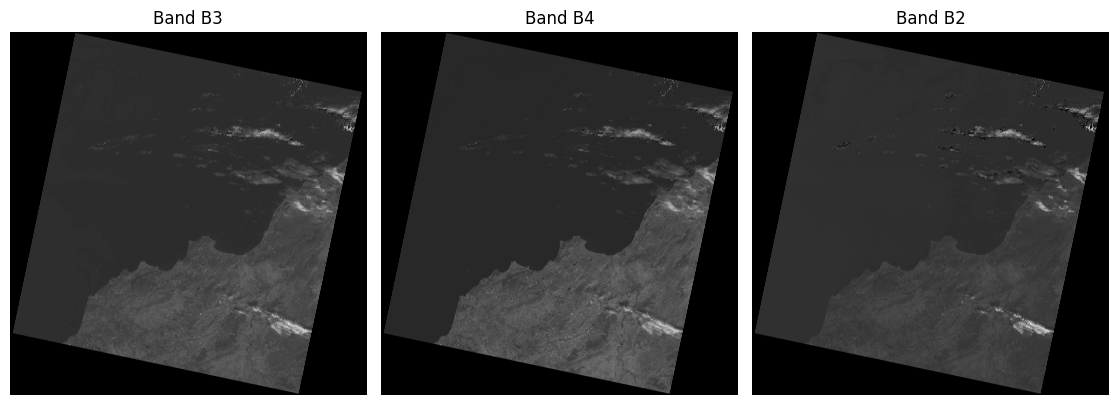

In [5]:
band_paths = {
    'B3': 'images/LC08_L2SP_198035_20240912_20240920_02_T1_SR_B3.TIF',
    'B4': 'images/LC08_L2SP_198035_20240912_20240920_02_T1_SR_B4.TIF',
    'B2': 'images/LC08_L2SP_198035_20240912_20240920_02_T1_SR_B2.TIF'
}
def read_band(band_path):
    with rasterio.open(band_path) as src:
        return src.read(1)

bands = {band_name: read_band(band_path) for band_name, band_path in band_paths.items()}
plt.figure(figsize=(15, 10))
for i, (band_name, band_data) in enumerate(bands.items(), 1):
    plt.subplot(2, 4, i)
    plt.imshow(band_data, cmap='gray')
    plt.title(f'Band {band_name}')
    plt.axis('off')

plt.tight_layout()
plt.show()

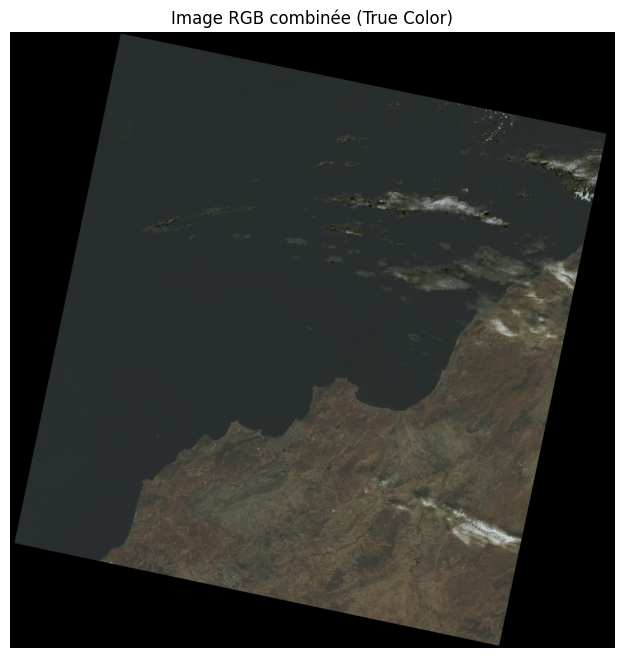

In [6]:
def normalize(band):
    return (band - np.min(band)) / (np.max(band) - np.min(band))
red = normalize(bands['B4'])    
green = normalize(bands['B3'])  
blue = normalize(bands['B2'])   
rgb = np.dstack((red, green, blue))
plt.figure(figsize=(8, 8))
plt.imshow(rgb)
plt.title('Image RGB combinée (True Color)')
plt.axis('off')
plt.show()

In [7]:
rgb = np.dstack((red, green, blue))
rgb_image = (rgb * 255).astype(np.uint8)  
pil_image = Image.fromarray(rgb_image)
pil_image.save('images/image_combinée_simple(true_color).tiff')
with rasterio.open('images/image_combinée_simple(true_color).tiff') as src:
    img = src.read([1, 2, 3])
    img = np.dstack(img) 
height, width, _ = img.shape
print(f"Dimensions de l'image : {width}x{height}")

c:\Users\M\AppData\Local\Programs\Python\Python311\Lib\site-packages\rasterio\__init__.py:368: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Dimensions de l'image : 7581x7721


Etape 1 : Opération géométrique

In [8]:
x = 1500  
y = 5400 
t1 = 400  
t2 = 400 

In [9]:
def cutimage(x, y, t1, t2, img, output_path):
    cut_img = img[y:y+t2, x:x+t1, :]
    cut_img_pil = Image.fromarray(cut_img)
    cut_img_pil.save(output_path)
    print(f"Zone découpée et enregistrée sous {output_path}")

cutimage(x, y, t1, t2, img, 'images/zone_decoupee.tiff')
height, width, _ = img.shape
print(f"Dimensions de l'image : {width}x{height}")

if (x + t1 <= width) and (y + t2 <= height):
    cutimage(x, y, t1, t2, img, 'Output_images/output_path.tiff')
else:
    print("Les coordonnées de découpe dépassent les dimensions de l'image.")

Zone découpée et enregistrée sous images/zone_decoupee.tiff
Dimensions de l'image : 7581x7721
Zone découpée et enregistrée sous Output_images/output_path.tiff


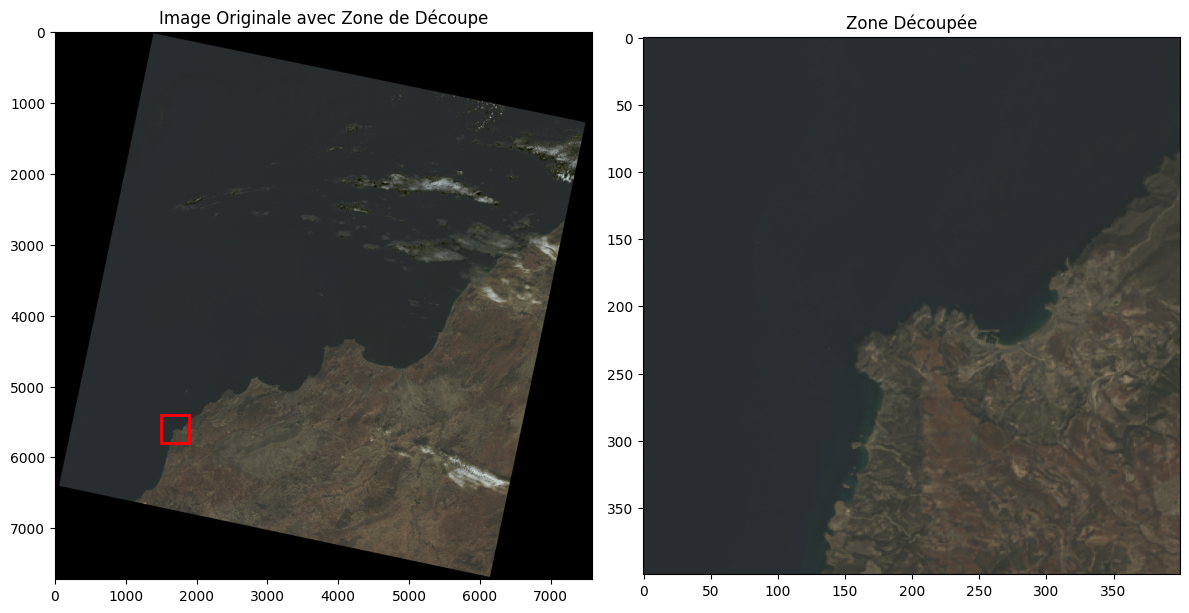

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].imshow(img)
rect = plt.Rectangle((x, y), t1, t2, linewidth=2, edgecolor='r', facecolor='none')
axs[0].add_patch(rect)
axs[0].set_title("Image Originale avec Zone de Découpe")
decoupee = np.array(Image.open('Output_images/output_path.png'))
axs[1].imshow(decoupee)
axs[1].set_title("Zone Découpée")
plt.tight_layout()  
plt.show()

Etape 2 : Compression

In [11]:
decoupee = Image.open('Output_images/output_path.png')

# Définir le dossier de sortie
output_folder = 'Output_images'

# S'assurer que le dossier de sortie existe
os.makedirs(output_folder, exist_ok=True)

# Sauvegarder sous différents formats
formats = ['bmp', 'jpeg', 'gif', 'tiff']
output_paths = []

for fmt in formats:
    output_file = os.path.join(output_folder, f'output_path.{fmt}')
    decoupee.save(output_file)
    output_paths.append(output_file)
    print(f"Image sauvegardée sous {fmt} : {output_file}")

# Afficher la taille de chaque fichier
for output_file in output_paths:
    file_size = os.path.getsize(output_file)
    print(f"Taille de {output_file} : {file_size / 1024:.2f} KB")

Image sauvegardée sous bmp : Output_images\output_path.bmp
Image sauvegardée sous jpeg : Output_images\output_path.jpeg
Image sauvegardée sous gif : Output_images\output_path.gif
Image sauvegardée sous tiff : Output_images\output_path.tiff
Taille de Output_images\output_path.bmp : 468.80 KB
Taille de Output_images\output_path.jpeg : 9.34 KB
Taille de Output_images\output_path.gif : 88.81 KB
Taille de Output_images\output_path.tiff : 468.89 KB


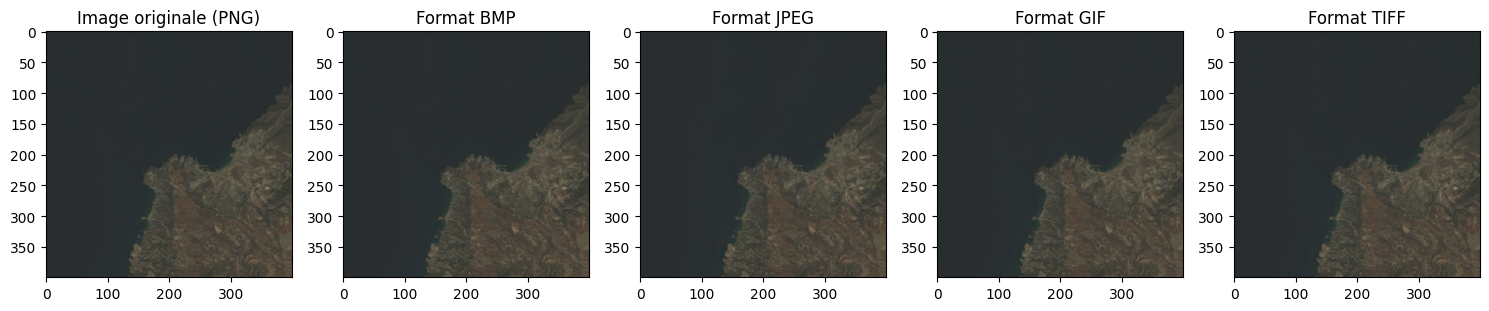

In [12]:
fig, axs = plt.subplots(1, len(formats) + 1, figsize=(15, 5))


axs[0].imshow(np.array(decoupee))
axs[0].set_title("Image originale (PNG)")
for i, fmt in enumerate(formats):
    img_compressed = Image.open(f'Output_images/output_path.{fmt}')
    
    if fmt == 'gif':
        img_compressed = img_compressed.convert("RGB")
        
    axs[i + 1].imshow(np.array(img_compressed))
    axs[i + 1].set_title(f"Format {fmt.upper()}")

plt.tight_layout()
plt.show()

In [13]:
#Fonction Prédefinie
def eqm_sklearn(img_source, img_result):
    """Calcule l'erreur quadratique moyenne entre deux images avec sklearn."""
    img_source_array = np.array(img_source)
    img_result_array = np.array(img_result)
    if img_source_array.shape != img_result_array.shape:
        raise ValueError("Les dimensions des images doivent être identiques.")
    return mean_squared_error(img_source_array.flatten(), img_result_array.flatten())

def eqm_manual(img_source, img_result):
    """Calcule l'erreur quadratique moyenne entre deux images avec une approche manuelle."""
    img1_array = np.array(img_source)
    img2_array = np.array(img_result)
    
    if img1_array.shape != img2_array.shape:
        raise ValueError("Les images doivent avoir les mêmes dimensions pour calculer l'EQM.")
    eqm_value = np.sum((img1_array.astype(float) - img2_array.astype(float)) ** 2) / img1_array.size
    
    return eqm_value

# Fonction de comparaison des deux résultats
def comparer_eqm(original_image_path, formats=['bmp', 'jpeg', 'gif', 'tiff']):
    original = Image.open(original_image_path)
    original_rgb = original.convert('RGB')
    for fmt in formats:
        try:
            compressed_image = Image.open(f'Output_images/output_path.{fmt}')
            compressed_rgb = compressed_image.convert('RGB')
            compressed_rgb = compressed_rgb.resize(original_rgb.size)
            eqm_value_sklearn = eqm_sklearn(original_rgb, compressed_rgb)
            eqm_value_manual = eqm_manual(original_rgb, compressed_rgb)
            
            # Comparer les résultats
            print(f"Format {fmt.upper()}:")
            print(f"  EQM (sklearn) : {eqm_value_sklearn:.4f}")
            print(f"  EQM (manuel)  : {eqm_value_manual:.4f}")
            print(f"  Différence    : {abs(eqm_value_sklearn - eqm_value_manual):.4f}\n")
        except FileNotFoundError:
            print(f"Erreur : L'image compressée '{fmt}' n'a pas été trouvée.")
        except Exception as e:
            print(f"Une erreur s'est produite avec le format {fmt.upper()}: {e}")
comparer_eqm('Output_images/output_path.png')


Format BMP:
  EQM (sklearn) : 0.0000
  EQM (manuel)  : 0.0000
  Différence    : 0.0000

Format JPEG:
  EQM (sklearn) : 4.2663
  EQM (manuel)  : 4.2663
  Différence    : 0.0000

Format GIF:
  EQM (sklearn) : 0.2997
  EQM (manuel)  : 0.2997
  Différence    : 0.0000

Format TIFF:
  EQM (sklearn) : 0.0000
  EQM (manuel)  : 0.0000
  Différence    : 0.0000



 Etape 3 : Rehaussement de contraste

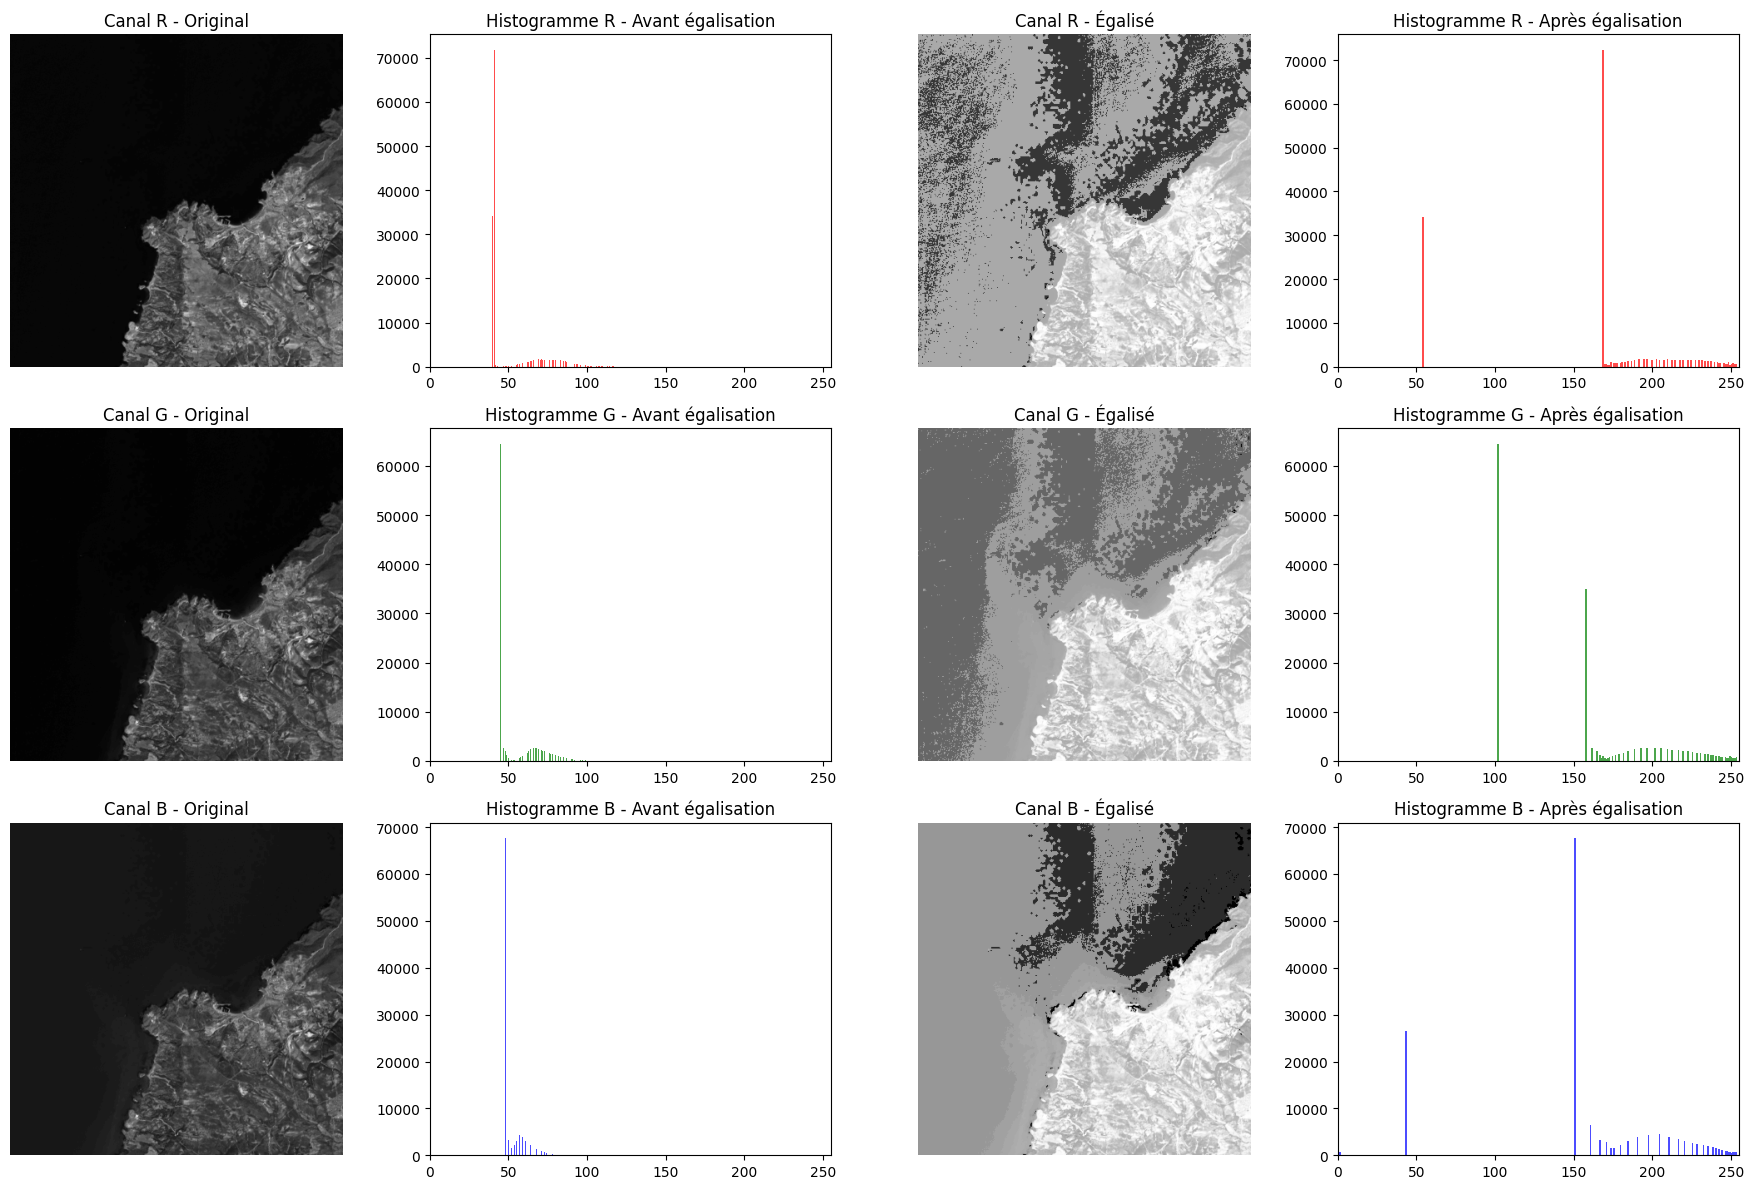

EQM entre l'image originale et l'image égalisée : 88.23751875


In [9]:
def histogram_equalization(image_channel):
    hist, bins = np.histogram(image_channel.flatten(), bins=256, range=[0, 256])
    cdf = hist.cumsum()
    cdf_m = np.ma.masked_equal(cdf, 0)
    cdf_m = (cdf_m - cdf_m.min()) * 255 / (cdf_m.max() - cdf_m.min())
    cdf_final = np.ma.filled(cdf_m, 0).astype('uint8') 
    return cdf_final[image_channel]

def eqm_manual(img_source, img_result):
    img1_array = np.array(img_source)
    img2_array = np.array(img_result)
    
    if img1_array.shape != img2_array.shape:
        raise ValueError("Les images doivent avoir les mêmes dimensions pour calculer l'EQM.")
    eqm_value = np.mean((img1_array - img2_array) ** 2)
    return eqm_value

img = Image.open('Output_images/output_path.png')
img = img.convert('RGB') 
r, g, b = img.split()

r_eq = histogram_equalization(np.array(r))
g_eq = histogram_equalization(np.array(g))
b_eq = histogram_equalization(np.array(b))
img_equalized = Image.merge('RGB', (Image.fromarray(r_eq), Image.fromarray(g_eq), Image.fromarray(b_eq)))
eqm_global = eqm_manual(np.array(img), np.array(img_equalized))
fig, axs = plt.subplots(3, 4, figsize=(18, 12))
channels = {'R': (r, r_eq, 'red'), 'G': (g, g_eq, 'green'), 'B': (b, b_eq, 'blue')}

for i, (color, (channel, channel_eq, col)) in enumerate(channels.items()):
    axs[i, 0].imshow(channel, cmap='gray')
    axs[i, 0].set_title(f'Canal {color} - Original')
    axs[i, 0].axis('off')
    axs[i, 1].hist(np.array(channel).flatten(), bins=256, color=col, alpha=0.7)
    axs[i, 1].set_title(f'Histogramme {color} - Avant égalisation')
    axs[i, 1].set_xlim(0, 255)
    axs[i, 2].imshow(channel_eq, cmap='gray')
    axs[i, 2].set_title(f'Canal {color} - Égalisé')
    axs[i, 2].axis('off')
    axs[i, 3].hist(channel_eq.flatten(), bins=256, color=col, alpha=0.7)
    axs[i, 3].set_title(f'Histogramme {color} - Après égalisation')
    axs[i, 3].set_xlim(0, 255)

plt.tight_layout()
plt.show()

print(f"EQM entre l'image originale et l'image égalisée : {eqm_global}")


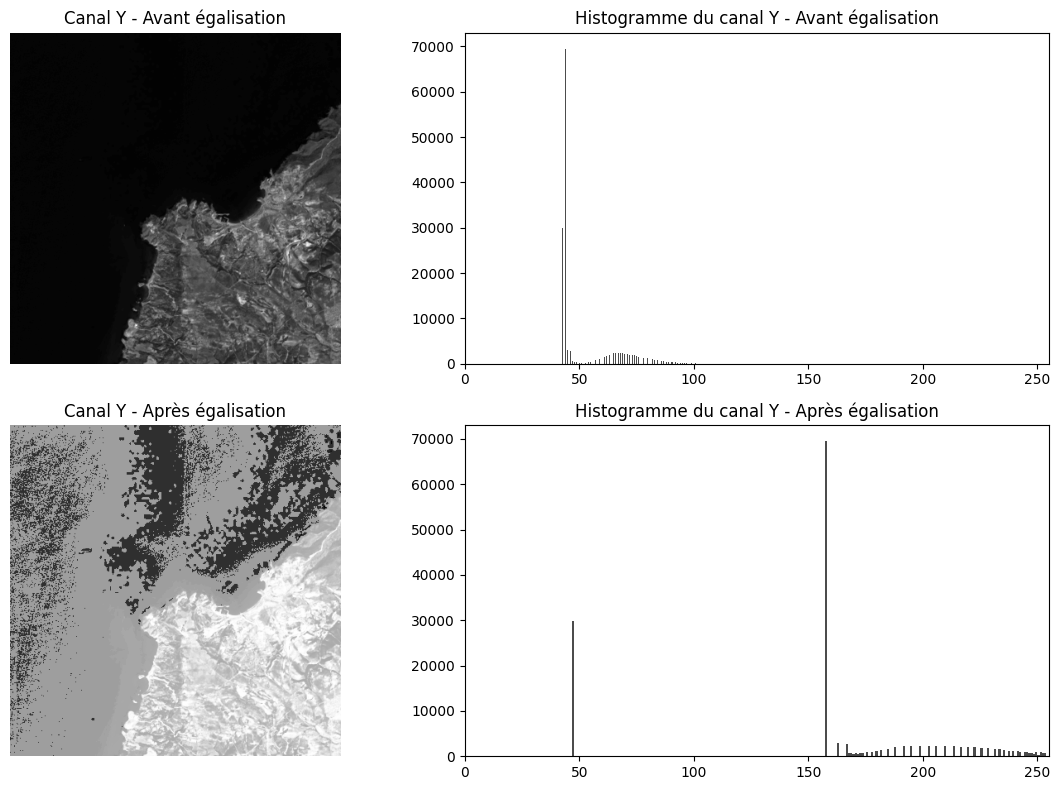

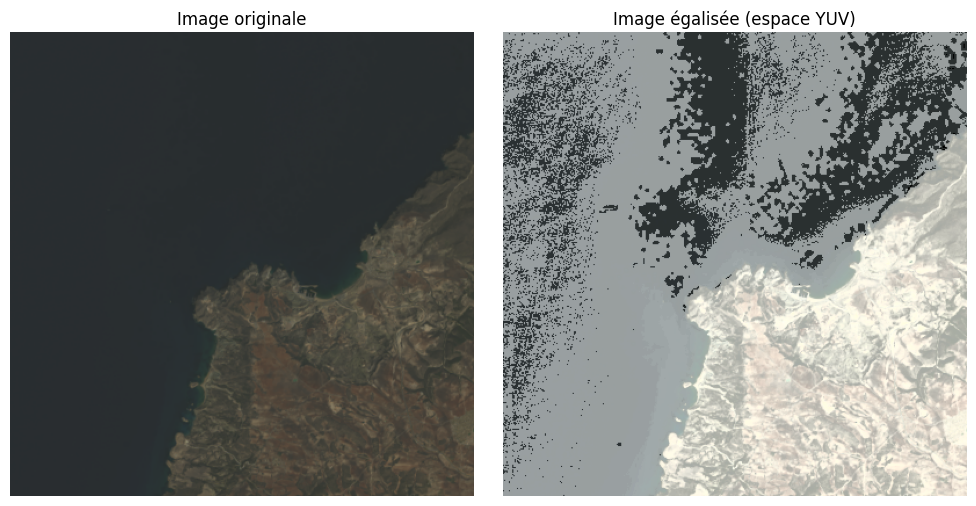

In [ ]:
def histogram_equalization(image_channel):
    hist, bins = np.histogram(image_channel.flatten(), bins=256, range=[0, 256])
    cdf = hist.cumsum()
    cdf_m = np.ma.masked_equal(cdf, 0)
    cdf_m = (cdf_m - cdf_m.min()) * 255 / (cdf_m.max() - cdf_m.min())
    cdf_final = np.ma.filled(cdf_m, 0).astype('uint8') 
    return cdf_final[image_channel]

def equalize_rgb_using_yuv(image):
    img_yuv = np.array(image.convert('YCbCr')) 
    y_channel, u, v = img_yuv[:, :, 0], img_yuv[:, :, 1], img_yuv[:, :, 2]
    y_eq = histogram_equalization(y_channel)
    img_yuv_eq = np.stack((y_eq, u, v), axis=2)
    img_equalized = Image.fromarray(img_yuv_eq, 'YCbCr').convert('RGB')
    
    return img_equalized, y_channel, y_eq


img = Image.open('Output_images/output_path.png').convert('RGB')
img_equalized_yuv, y_original, y_eq = equalize_rgb_using_yuv(img)
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
axs[0, 0].imshow(y_original, cmap='gray')
axs[0, 0].set_title("Canal Y - Avant égalisation")
axs[0, 0].axis('off')
axs[0, 1].hist(y_original.flatten(), bins=256, color='black', alpha=0.7)
axs[0, 1].set_title("Histogramme du canal Y - Avant égalisation")
axs[0, 1].set_xlim(0, 255)
axs[1, 0].imshow(y_eq, cmap='gray')
axs[1, 0].set_title("Canal Y - Après égalisation")
axs[1, 0].axis('off')
axs[1, 1].hist(y_eq.flatten(), bins=256, color='black', alpha=0.7)
axs[1, 1].set_title("Histogramme du canal Y - Après égalisation")
axs[1, 1].set_xlim(0, 255)
plt.tight_layout()
plt.show()
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title('Image originale')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(img_equalized_yuv)
plt.title("Image égalisée (espace YUV)")
plt.axis('off')
plt.tight_layout()
plt.show()

Etape 4 : Reduction du bruit

Filtre Moyenne - MSE: 5.1973147492390126e-05


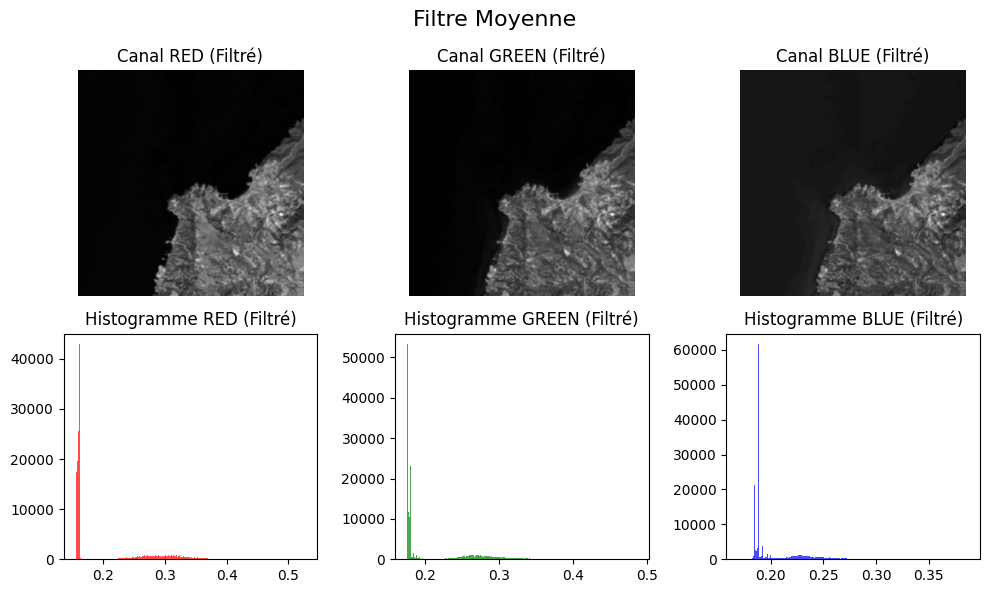

Filtre Gaussien - MSE: 3.260573430452496e-05


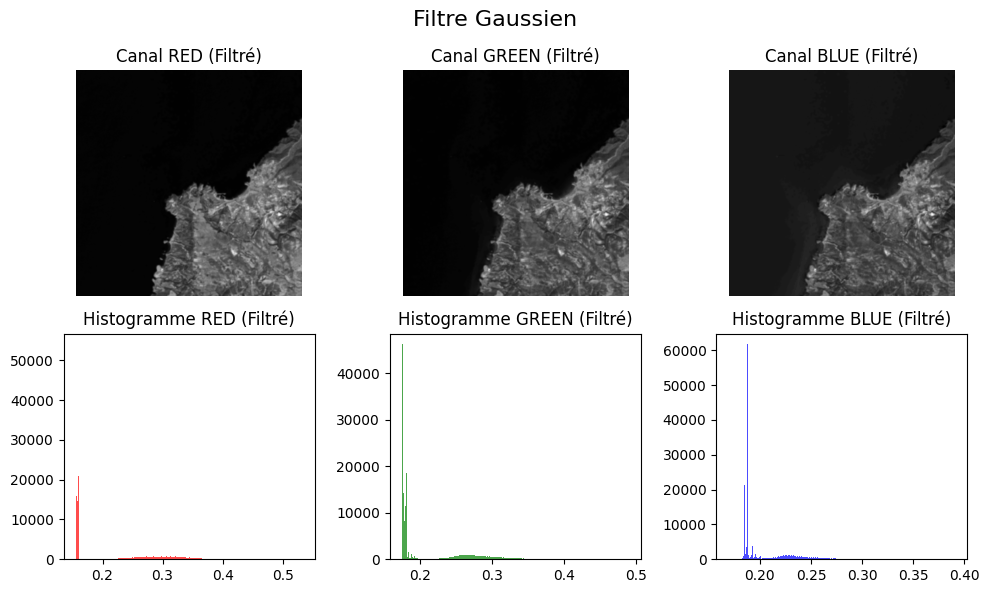

Filtre Médian - MSE: 4.530981459538452e-05


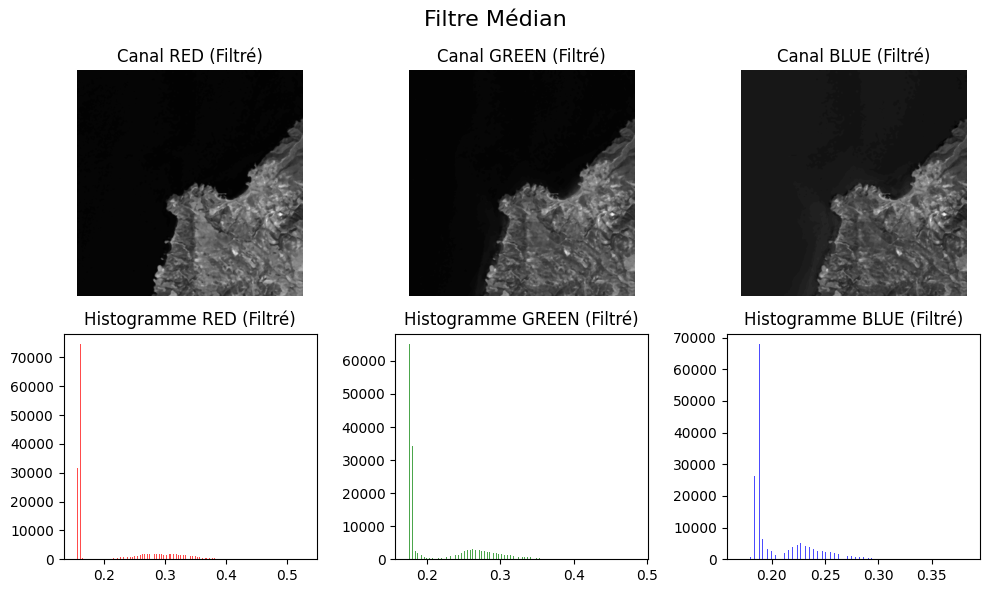

Filtre Max - MSE: 0.00041417204192839563


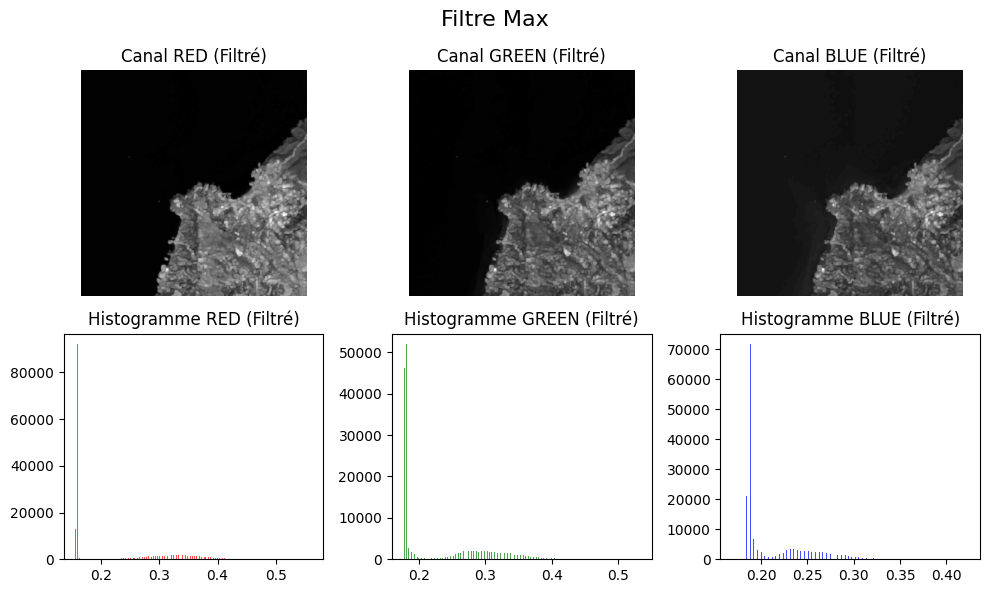

Filtre Min - MSE: 0.00034171182778663933


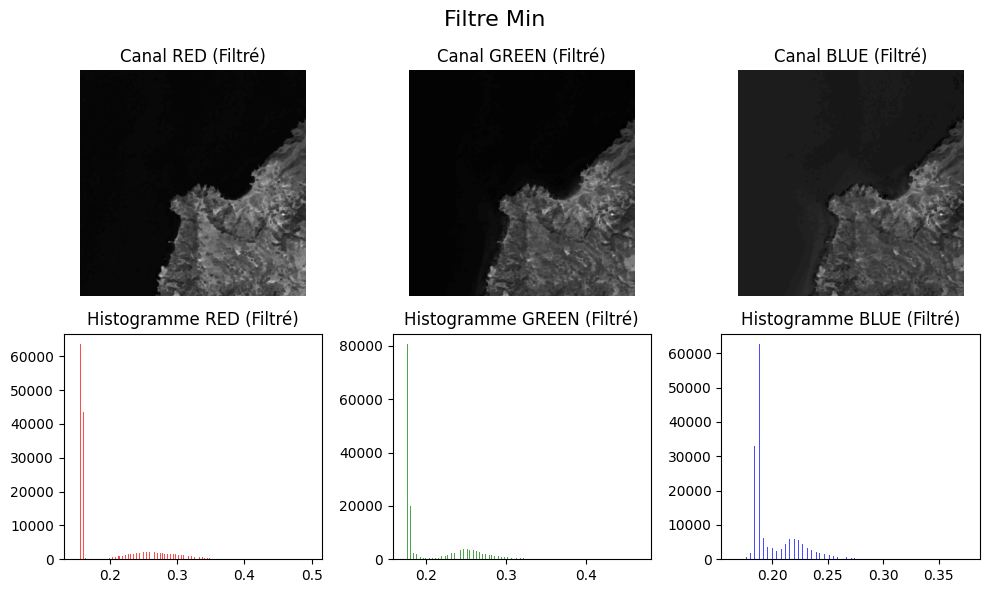

In [13]:
def filtre_moyenne(img):
    kernel = np.ones((3, 3)) / 9.0  
    pad_img = np.pad(img, 1, mode='reflect')  
    result = np.zeros_like(img)
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            result[i, j] = np.sum(pad_img[i:i+3, j:j+3] * kernel)
    return result

def filtre_gaussien(img):
    kernel = np.array([[1, 2, 1],
                       [2, 4, 2],
                       [1, 2, 1]]) / 16.0
    pad_img = np.pad(img, 1, mode='reflect')
    result = np.zeros_like(img)
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            result[i, j] = np.sum(pad_img[i:i+3, j:j+3] * kernel)
    return result

def filtre_median(img):
    pad_img = np.pad(img, 1, mode='reflect')
    result = np.zeros_like(img)
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            result[i, j] = np.median(pad_img[i:i+3, j:j+3])
    return result


def filtre_max(img):
    pad_img = np.pad(img, 1, mode='reflect')
    result = np.zeros_like(img)
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            result[i, j] = np.max(pad_img[i:i+3, j:j+3])
    return result

def filtre_min(img):
    pad_img = np.pad(img, 1, mode='reflect')
    result = np.zeros_like(img)
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            result[i, j] = np.min(pad_img[i:i+3, j:j+3])
    return result

def afficher_image_et_histogramme(img_originale, img_filtree, titre="Image filtrée"):
    fig, axs = plt.subplots(2, 3, figsize=(10, 6))
    fig.suptitle(titre, fontsize=16)
    R_originale, G_originale, B_originale = img_originale[..., 0], img_originale[..., 1], img_originale[..., 2]
    R_filtree, G_filtree, B_filtree = img_filtree[..., 0], img_filtree[..., 1], img_filtree[..., 2]
    for i, (originale, filtree, color) in enumerate(zip([R_originale, G_originale, B_originale],
                                                        [R_filtree, G_filtree, B_filtree],
                                                        ['red', 'green', 'blue'])):
        axs[0, i].imshow(filtree, cmap='gray')
        axs[0, i].set_title(f"Canal {color.upper()} (Filtré)")
        axs[0, i].axis('off')
        axs[1, i].hist(filtree.ravel(), bins=256, color=color, alpha=0.7)
        axs[1, i].set_title(f"Histogramme {color.upper()} (Filtré)")
    plt.tight_layout()
    plt.show()

def appliquer_filtres_et_calculer_mse(img, eqm_manuelle):
    R, G, B = img[..., 0], img[..., 1], img[..., 2]
    resultats = {
        "Filtre Moyenne": filtre_moyenne,
        "Filtre Gaussien": filtre_gaussien,
        "Filtre Médian": filtre_median,
        "Filtre Max": filtre_max,
        "Filtre Min": filtre_min
    }

    for nom, filtre in resultats.items():
        R_filtree = filtre(R)
        G_filtree = filtre(G)
        B_filtree = filtre(B)
        img_filtree = np.stack((R_filtree, G_filtree, B_filtree), axis=-1)
        mse = eqm_manual(img, img_filtree)
        print(f"{nom} - MSE: {mse}")
        afficher_image_et_histogramme(img, img_filtree, titre=f"{nom}")
img = plt.imread('Output_images/output_path.png')
if img.ndim == 3 and img.shape[2] == 4:  
    img = img[..., :3] 
appliquer_filtres_et_calculer_mse(img, eqm_manual)
